In [1]:
'''This script demonstrates how to entangle digit with fashion mnist
'''
import sys, os
os.environ['CUDA_VISIBLE_DEVICES'] = ''
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Layer
from keras.layers import Conv2D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras import metrics
import keras
sys.path.append(os.path.expanduser('~/notebook'))
from tools import plot_confusion_matrix, plot_model, layers, nb_tools, viz, loader, build_model, sanity, sampling, custom_variational_layer, metrics, build_model

# input image dimensions
img_rows, img_cols, img_chns = 28, 28, 1
if K.image_data_format() == 'channels_first':
    original_img_size = (img_chns, img_rows, img_cols)
else:
    original_img_size = (img_rows, img_cols, img_chns)


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
images_digits, gt_set_digits, _, _ = loader.mnist((28, 28, 1), 'digit')
images_fashion, gt_set_fashion, _, _ = loader.mnist((28, 28, 1), 'fashion')
# reorder
gt_set_digits_argument = np.argsort(gt_set_digits)
gt_set_fashion_argument = np.argsort(gt_set_fashion)
x_set = images_digits[gt_set_digits_argument,:]
w_set = images_fashion[gt_set_fashion_argument,:]
gt_set_digits = gt_set_digits[gt_set_digits_argument]
gt_set_fashion = gt_set_fashion[gt_set_fashion_argument]
# cut each class to the same lenght
x_set_idx = np.array([], dtype=np.int)
w_set_idx = np.array([], dtype=np.int)
for idx in np.arange(0,np.min([len(x_set), len(w_set)]), dtype=np.int):
    if gt_set_digits[idx] == gt_set_fashion[idx]:
        x_set_idx = np.concatenate((x_set_idx, [idx]))
        w_set_idx = np.concatenate((w_set_idx, [idx]))
x_set = x_set[x_set_idx,:]
w_set = w_set[w_set_idx,:]
gt_set_digits = gt_set_digits[x_set_idx]
gt_set_fashion = gt_set_fashion[w_set_idx]
# Check
if np.all(gt_set_digits == gt_set_fashion):
    print("nice")
else:
    print("not nice")
    raise
gt_set = gt_set_digits
size = len(gt_set_digits)

nice


----------------- label:  0


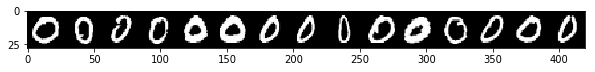

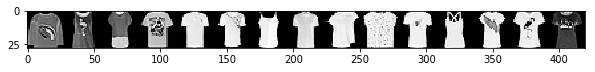

----------------- label:  1


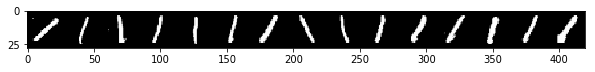

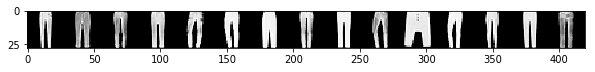

----------------- label:  2


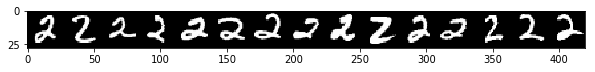

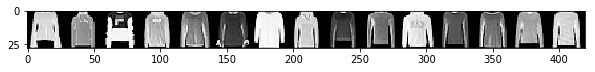

----------------- label:  3


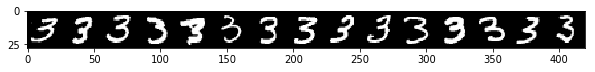

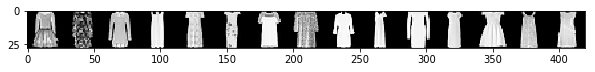

----------------- label:  4


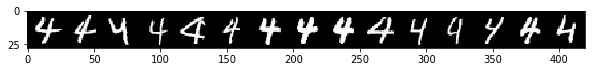

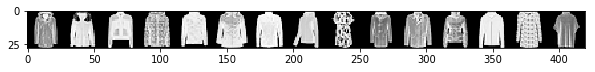

----------------- label:  5


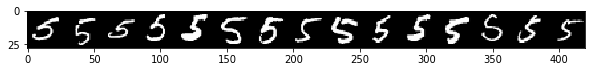

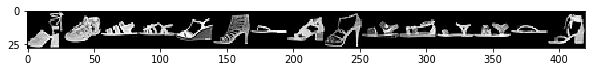

----------------- label:  6


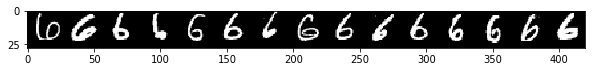

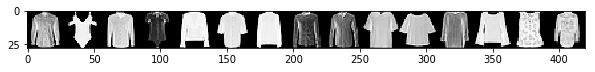

----------------- label:  7


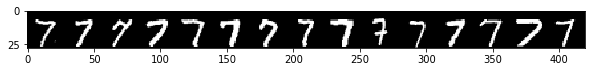

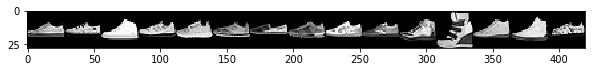

----------------- label:  8


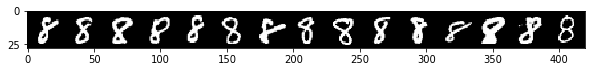

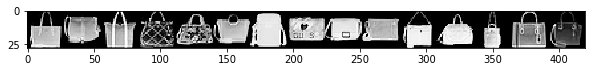

----------------- label:  9


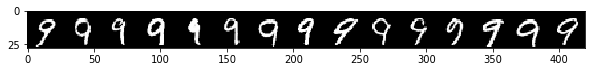

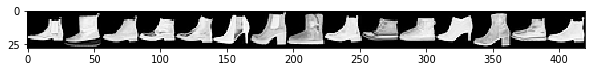

In [13]:
def print_x(data_set, gt_set, label, num_y = None):
    # display a 2D manifold of the digits
    n = num_y
    digit_size = 28
    figure = np.zeros((digit_size, digit_size * n))
    _data_set = data_set[gt_set == label,:]
    for j in np.arange(0,n):
        for i in np.arange(0,1):
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = _data_set[j,:,:,0]

    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='Greys_r')
    plt.show(block=False)


for label in np.arange(0,10):
    num_y = np.int(15)
    print("----------------- label: ", label)
    # plot the decoded images
    print_x(x_set, gt_set, label, num_y = num_y)
    print_x(w_set, gt_set, label, num_y = num_y)


----------------- label:  0


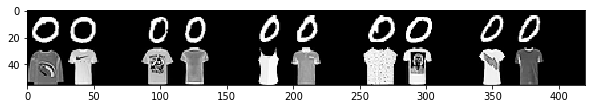

----------------- label:  1


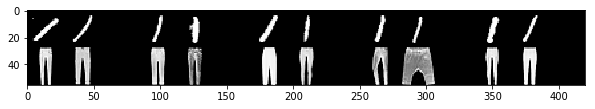

----------------- label:  2


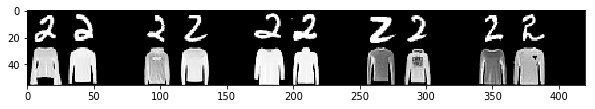

----------------- label:  3


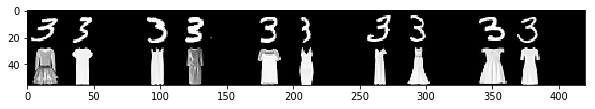

----------------- label:  4


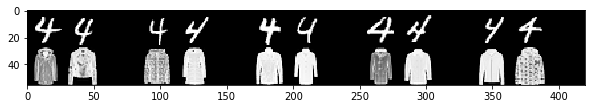

----------------- label:  5


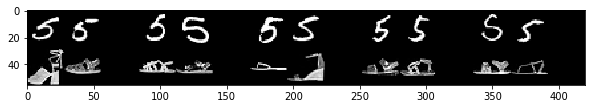

----------------- label:  6


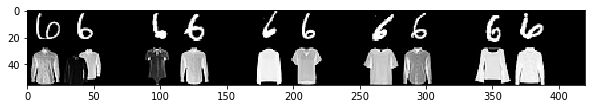

----------------- label:  7


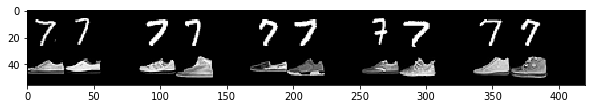

----------------- label:  8


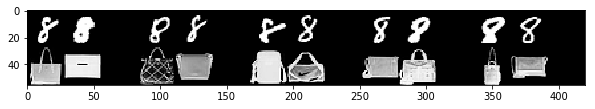

----------------- label:  9


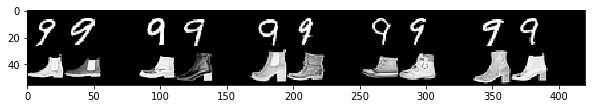

In [28]:
def print_x(data_set, data_set_fashion, gt_set, label, num_y = None):
    # display a 2D manifold of the digits
    n = num_y
    digit_size = 28
    figure = np.zeros((digit_size * 2, digit_size * n))
    _data_set         = data_set[gt_set == label,:]
    _data_set_fashion = data_set_fashion[gt_set == label,:]
    for j in np.arange(0,n,3):
        for i in np.arange(0,1):
            # plot the first digit fhasion tuple
            _data_set = data_set[gt_set == label,:]
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = _data_set[j,:,:,0]
            figure[(i+1) * digit_size: (i + 2) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = _data_set_fashion[j,:,:,0]
            
            # Show the next similar digit
            _data_set_flat = x_set.reshape((len(x_set), np.prod(x_set.shape[1:])))
            _data_set_mse = np.sqrt(np.sum((_data_set_flat - _data_set_flat[j,:])**2, axis=1))
            _data_set_mse[j] = np.inf
            _data_set_similar_digit_arg = np.argmin(_data_set_mse)
            figure[i * digit_size: (i + 1) * digit_size,
                   (j+1) * digit_size: (j + 2) * digit_size] = _data_set[_data_set_similar_digit_arg,:,:,0]
            figure[(i+1) * digit_size: (i + 2) * digit_size,
                   (j+1) * digit_size: (j + 2) * digit_size] = _data_set_fashion[_data_set_similar_digit_arg,:,:,0]

    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='Greys_r')
    plt.show(block=False)


for label in np.arange(0,10):
    num_y = np.int(15)
    print("----------------- label: ", label)
    # plot the decoded images
    print_x(x_set, w_set, gt_set, label, num_y = num_y)


In [ ]:
#from scipy.stats import norm
#print(norm.ppf(np.linspace(0.05, 0.95, 3)))